In [1]:
import os
import cv2
import numpy as np

from torch.utils.data import DataLoader

import argus
from argus import Model
from argus.callbacks import MonitorCheckpoint, EarlyStopping
from argus.callbacks import LoggingToFile, ReduceLROnPlateau

from src.datasets import DrawDataset, get_train_val_samples
from src.transforms import ImageTransform, DrawTransform
from src.argus_models import CnnFinetune, DrawMetaModel, IterSizeMetaModel
from src.metrics import MAPatK
from src import config

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def imshow(image, figsize=(3, 3)):
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.show()

In [3]:
image_size = 256
scale_size = 128
image_pad = 3
image_line_width = 3
time_color = True
iter_size = 5
train_batch_size = 208 * iter_size
val_batch_size = 208 * iter_size
train_epoch_size = 1000000
val_key_id_path = '/workdir/data/val_key_ids_001.json'
blacklist_path = '/workdir/data/blacklist_0.6.json'

# Data

In [4]:
train_samples, val_samples = get_train_val_samples(val_key_id_path, blacklist_path)

100%|██████████| 340/340 [07:09<00:00,  1.26s/it]


In [5]:
draw_transform = DrawTransform(image_size, image_pad, image_line_width, time_color)
train_trns = ImageTransform(True, scale_size)
train_dataset = DrawDataset(train_samples, draw_transform,
                            size=train_epoch_size, image_transform=train_trns)
val_trns = ImageTransform(False, scale_size)
val_dataset = DrawDataset(val_samples, draw_transform, image_transform=val_trns)

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, num_workers=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=val_batch_size, num_workers=8, shuffle=False)

laptop


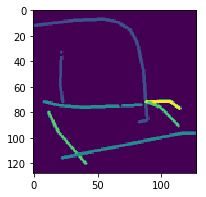

hand


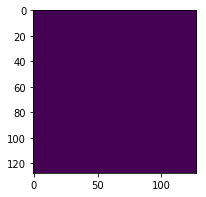

coffee cup


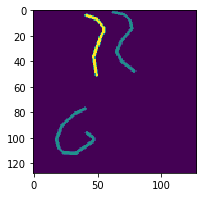

In [6]:
n_images_to_draw = 3

for img, trg in train_loader:
    for i in range(n_images_to_draw):
        img_i = img[0][i, 0, :, :].numpy()
        print(config.IDX_TO_CLASS[trg[i].item()])
        imshow(img_i)
    break

# Model

In [7]:
params = {
    'nn_module': ('CountryEmbModel' ,{
        'cnn_finetune': {
            'model_name': 'se_resnext50_32x4d',
            'num_classes': len(config.CLASSES),
            'pretrained': True,
            'dropout_p': 0.2
        },
        'num_country': len(config.COUNTRIES),
        'country_emb_dim': 10
    }),
    'iter_size': iter_size,
    'optimizer': ('Adam', {'lr': 0.001}),
    'loss': 'CrossEntropyLoss',
    'device': 'cuda'
}

model = IterSizeMetaModel(params)

In [ ]:
experiment_name = 'iter_size_se_resnext50_002'

callbacks = [
    MonitorCheckpoint(f'/workdir/data/experiments/{experiment_name}', monitor='val_map_at_k', max_saves=10),
    EarlyStopping(monitor='val_map_at_k', patience=50),
    ReduceLROnPlateau(monitor='val_map_at_k', factor=0.64, patience=1, min_lr=1e-7),
    LoggingToFile(f'/workdir/data/experiments/{experiment_name}/log.txt')
]

model.fit(train_loader, 
          val_loader=val_loader,
          max_epochs=1000,
          callbacks=callbacks,
          metrics=['accuracy', MAPatK(k=3)])

2018-12-01 08:20:46,367 INFO Validation, val_loss: 5.84292159, val_accuracy: 0.00402435, val_map_at_k: 0.00660995


# Predict 

In [ ]:
0.0000001import torch


class Predictor:
    def __init__(self, model_path, draw_transform, image_transform):
        self.model = load_model(model_path)
        self.model.nn_module.eval()

        self.draw_transform = draw_transform
        self.image_transform = image_transform

    def __call__(self, samples):
        tensors = []
        country_tensors = []
        for drawing, country in samples:
            image = self.draw_transform(drawing)
            tensor = self.image_transform(image)
            if country == 'OTHER':
                country = 'nan'
            country = torch.tensor(config.COUNTRY_TO_IDX[country])
            country_tensors.append(country)
            tensors.append(tensor)
        
        tensor = torch.stack(tensors, dim=0)
        tensor = tensor.to(self.model.device)
        
        country_tensor = torch.stack(country_tensors, dim=0)
        country_tensor = country_tensor.to(self.model.device)

        with torch.no_grad():
            probs = self.model.predict((tensor, country_tensor))
            return probs


In [ ]:
import pandas as pd
from src import config
import tqdm

from argus import load_model

pred_batch_size = 1024 
model_path = '/workdir/data/experiments/rainbow_country_se_resnext50_001/model-109-0.885694.pth'

test_df = pd.read_csv(config.TEST_SIMPLIFIED_PATH)
sample_subm = pd.read_csv(config.SAMPLE_SUBMISSION)
predictor = Predictor(model_path, draw_transform, val_trns)

drawings = []
key_ids = []
pred_words = []
pred_key_ids = []
for i, row in tqdm.tqdm(test_df.iterrows()):
    drawing = eval(row.drawing)
    
    drawings.append((drawing, str(row.countrycode)))
    key_ids.append(row.key_id)
    if len(drawings) == pred_batch_size:
        probs = predictor(drawings).cpu().numpy()
        preds_idx = probs.argsort(axis=1)
        preds_idx = np.fliplr(preds_idx)[:, :3]
        for pred_idx, key_id in zip(preds_idx, key_ids):
            words = [config.IDX_TO_CLASS[i].replace(' ', '_') for i in pred_idx]
            pred_words.append(" ".join(words))
            pred_key_ids.append(key_id)
            
        drawings = []
        key_ids = []
        
probs = predictor(drawings).cpu().numpy()
preds_idx = probs.argsort(axis=1)
preds_idx = np.fliplr(preds_idx)[:, :3]
for pred_idx, key_id in zip(preds_idx, key_ids):
    words = [config.IDX_TO_CLASS[i].replace(' ', '_') for i in pred_idx]
    pred_words.append(" ".join(words))
    pred_key_ids.append(key_id)

drawings = []
key_ids = []
    
subm = pd.DataFrame({'key_id': pred_key_ids, 'word': pred_words})

In [ ]:
subm.to_csv('/workdir/data/rainbow_country_se_resnext50_001.csv', index=False)